In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# I want to load a csv placed in ../logs/log_ear_mar.csv
# with this header timestamp;path_img;ear;mar

# And load into a dataframe using pandas

file_path = "../logs/log_ear_mar.csv"

df = pd.read_csv(file_path, sep=";")

In [25]:
df['category'] = df['path_img'].apply(lambda x: x.split('/')[2])
df

# cast ear and mar to float
df['ear'] = df['ear'].astype(float)
df['mar'] = df['mar'].astype(float)

In [26]:
df

,timestamp,path_img,ear,mar,category
0,20230911220029563455,./frames/bostezo/frame_20230911220029563455.jpg,0.140504,0.682872,bostezo
1,20230911220029682586,./frames/bostezo/frame_20230911220029682586.jpg,0.147645,0.800760,bostezo
2,20230911220029743451,./frames/bostezo/frame_20230911220029743451.jpg,0.189989,0.849610,bostezo
3,20230911220029822007,./frames/bostezo/frame_20230911220029822007.jpg,0.132697,0.818756,bostezo
4,20230911220029908184,./frames/bostezo/frame_20230911220029908184.jpg,0.159582,0.852484,bostezo
...,...,...,...,...,...
1575,20230912210706918804,./frames/bostezando/frame_20230912210706918804...,0.164574,0.074074,bostezando
1576,20230912210706965508,./frames/bostezando/frame_20230912210706965508...,0.193929,0.039208,bostezando
1577,20230912210707008677,./frames/bostezando/frame_20230912210707008677...,0.193929,0.039208,bostezando
1578,20230912210707056198,./frames/bostezando/frame_20230912210707056198...,0.242444,0.037729,bostezando


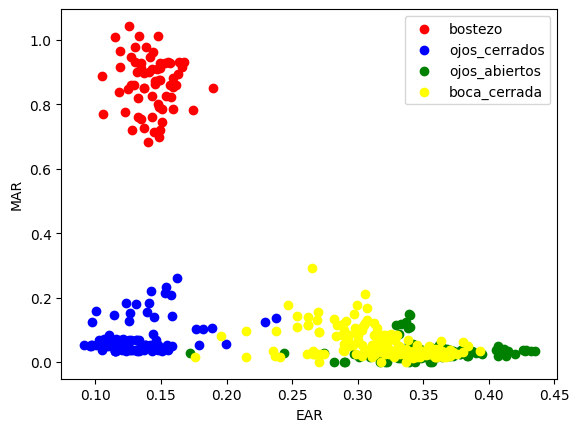

In [19]:
# plot ear vs mar, coloring different categories
colors = {
    'bostezo': 'red',
    'ojos_cerrados': 'blue',
    'ojos_abiertos': 'green',
    'boca_cerrada': 'yellow',
}

# Plot a scatter plot with labels per category
for category in colors.keys():
    plt.scatter(df[df['category'] == category]['ear'], df[df['category'] == category]['mar'], c=colors[category], label=category)

plt.xlabel('EAR')
plt.ylabel('MAR')
plt.legend()
plt.show()


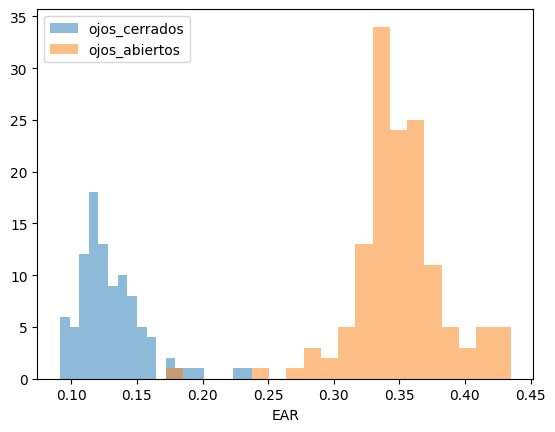

In [18]:
# Create a distribution plot for categories ojos_cerrados and ojos_abiertos for EAR
plt.hist(df[df['category'] == 'ojos_cerrados']['ear'], bins=20, alpha=0.5, label='ojos_cerrados')
plt.hist(df[df['category'] == 'ojos_abiertos']['ear'], bins=20, alpha=0.5, label='ojos_abiertos')
plt.xlabel('EAR')
plt.legend()
plt.show()

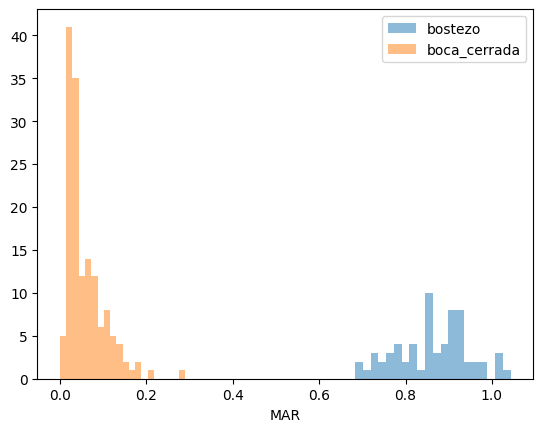

In [17]:
# Create a distribution plot for categories bostezo and boca_cerrada for MAR
plt.hist(df[df['category'] == 'bostezo']['mar'], bins=20, alpha=0.5, label='bostezo')
plt.hist(df[df['category'] == 'boca_cerrada']['mar'], bins=20, alpha=0.5, label='boca_cerrada')
plt.xlabel('MAR')
plt.legend()

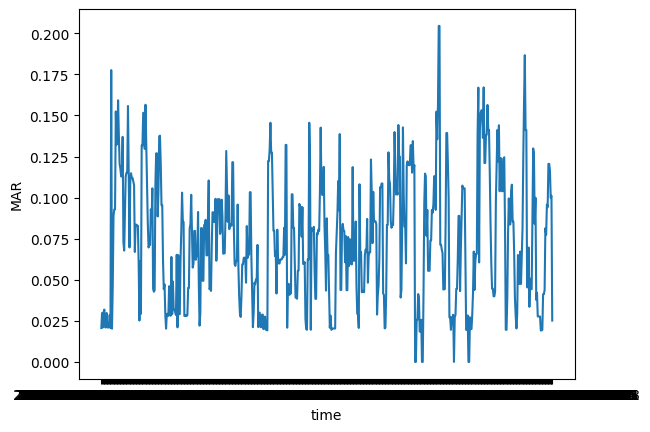

In [23]:
# Plot MAR vs time for "hablando" category
plt.plot(df[df['category'] == 'hablando']['timestamp'], df[df['category'] == 'hablando']['mar'])
plt.xlabel('time')
plt.ylabel('MAR')
plt.show()

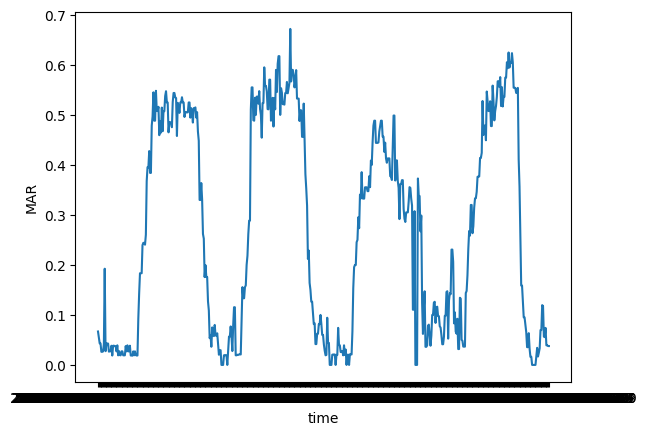

In [28]:
# Plot MAR vs time for "bostezando" category
plt.plot(df[df['category'] == 'bostezando']['timestamp'], df[df['category'] == 'bostezando']['mar'])
plt.xlabel('time')
plt.ylabel('MAR')
plt.show()